## data updates with high frequency for the helioforecast.space website

Main author: C. Möstl, Austrian Space Weather Office, GeoSphere Austria

https://github.com/cmoestl/heliocats

uses environment 'envs/env_helio4.yml'

In [8]:
# https://github.com/cmoestl/heliocats  data_update_web_hf.py

# for updating data with high frequency on the servers

# MIT LICENSE
# Copyright 2020-2023, Christian Moestl 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this 
# software and associated documentation files (the "Software"), to deal in the Software
# without restriction, including without limitation the rights to use, copy, modify, 
# merge, publish, distribute, sublicense, and/or sell copies of the Software, and to 
# permit persons to whom the Software is furnished to do so, subject to the following 
# conditions:
# The above copyright notice and this permission notice shall be included in all copies 
# or substantial portions of the Software.
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, 
# INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A
# PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT 
# HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF 
# CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE 
# OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

import pickle
import importlib
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import sys
import numpy as np
import datetime
import scipy.signal
import urllib
import json
import os   
import time
import h5py
import pytz
import copy
import cdflib

#import 
from heliocats import data as hd
importlib.reload(hd) #reload again while debugging

from heliocats import plot as hp
importlib.reload(hp) #reload again while debugging



################################################ CHECK  ##############################################
matplotlib.use('Agg')   #for server
#%matplotlib inline     

import os
os.system('jupyter nbconvert --to script data_update_web_hf.ipynb')   


#switches
get_noaa=1
get_stereoa=1

####################################################################################################################

#test execution times
t0all = time.time()


[NbConvertApp] Converting notebook data_update_web_hf.ipynb to script
[NbConvertApp] Writing 7209 bytes to data_update_web_hf.py


### Configure paths


In [2]:
from config import data_path


print(' ')
print('------ PATHS ')

print(data_path)

plot_path=data_path+'plots/'
position_path=data_path+'plots_positions/'
sun_path=data_path+'plots_sun/'

print(plot_path)
print(position_path)

from config import noaa_path
print(noaa_path)

from config import wind_path
print(wind_path)

from config import stereoa_path
print(stereoa_path)

from config import data_path_ml
print(data_path_ml)


########### make directories first time
if os.path.isdir(plot_path) == False: os.mkdir(plot_path)
if os.path.isdir(plot_path+'omni2') == False: os.mkdir(plot_path+'omni2')
if os.path.isdir(plot_path+'wind') == False: os.mkdir(plot_path+'wind')
if os.path.isdir(plot_path+'stereoa') == False: os.mkdir(plot_path+'stereoa')
if os.path.isdir(plot_path+'combined') == False: os.mkdir(plot_path+'combined')


if os.path.isdir(position_path) == False: os.mkdir(position_path)
if os.path.isdir(sun_path) == False: os.mkdir(sun_path)
if os.path.isdir(noaa_path) == False: os.mkdir(noaa_path)
if os.path.isdir(data_path_ml) == False: os.mkdir(data_path_ml)

 
------ PATHS 
/Users/chris/python/data/insitu_python/
/Users/chris/python/data/insitu_python/plots/
/Users/chris/python/data/insitu_python/plots_positions/
/Users/chris/python/ops/data/noaa/
/Users/chris/python/data/wind/
/Users/chris/python/data/stereoa/
/Users/chris/python/data/insitu_python/ML_struct_arrays/


### NOAA real time solar wind and Dst

 
------ NOAA real time solar wind data 
download NOAA real time solar wind plasma and mag and dst
2023-07-13 UTC
/Users/chris/python/ops/data/noaa/plasma/plasma-7-day_2023-07-13.json
/Users/chris/python/ops/data/noaa/mag/mag-7-day_2023-07-13.json
/Users/chris/python/ops/data/noaa/dst/dst-7-day_2023-07-13.json
NOAA download complete
 
convert NOAA real time solar wind archive to pickle file
directories for the json data
/Users/chris/python/ops/data/noaa/mag/
Sorted file list to be read with cutoff  100  files. 
['mag-7-day_2023-07-11T08h.json' 'mag-7-day_2023-07-11T09h.json'
 'mag-7-day_2023-07-11T11h.json' 'mag-7-day_2023-07-11T12h.json'
 'mag-7-day_2023-07-11T13h.json' 'mag-7-day_2023-07-13.json']
/Users/chris/python/ops/data/noaa/plasma/
['plasma-7-day_2023-07-11T08h.json' 'plasma-7-day_2023-07-11T09h.json'
 'plasma-7-day_2023-07-11T11h.json' 'plasma-7-day_2023-07-11T12h.json'
 'plasma-7-day_2023-07-11T13h.json' 'plasma-7-day_2023-07-13.json']

saved as  /Users/chris/python/data/ins

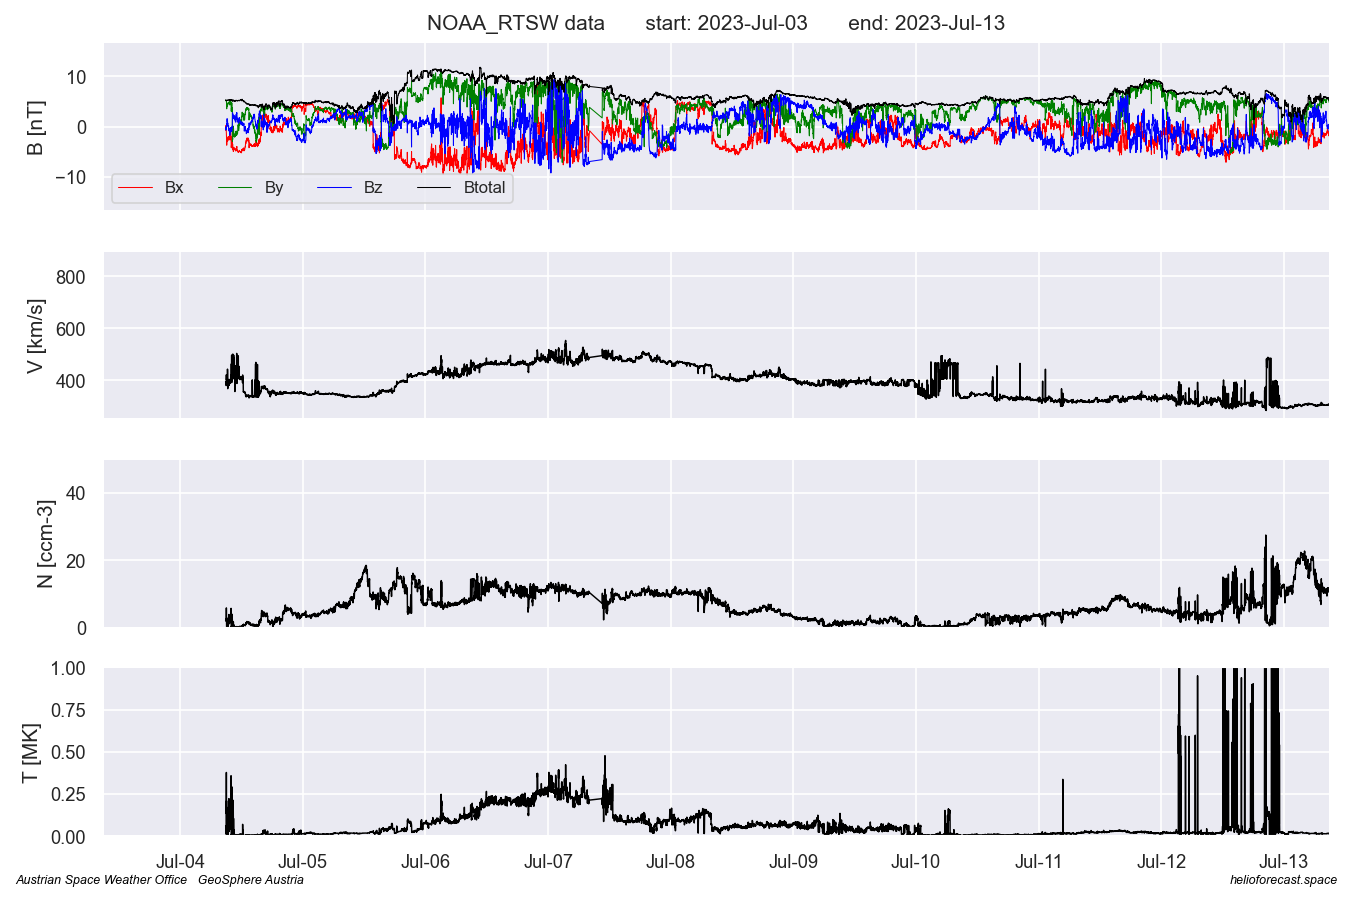

In [3]:
print(' ')
print('------ NOAA real time solar wind data ')

#test execution times
t0 = time.time()


if get_noaa > 0:
    print('download NOAA real time solar wind plasma and mag and dst')
    datestr=str(datetime.datetime.utcnow().strftime("%Y-%m-%d"))
    print(datestr+' UTC')

    plasma='http://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json'
    mag='http://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json'
    dst='https://services.swpc.noaa.gov/products/kyoto-dst.json'

    try: 
        urllib.request.urlretrieve(plasma, noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
        print(noaa_path+'plasma/plasma-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', plasma,' ',e.reason)

    try: 
        urllib.request.urlretrieve(mag, noaa_path+'mag/mag-7-day_'+datestr+'.json')
        print(noaa_path+'mag/mag-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
        

    try: 
        urllib.request.urlretrieve(dst, noaa_path+'dst/dst-7-day_'+datestr+'.json')
        print(noaa_path+'dst/dst-7-day_'+datestr+'.json')
    except urllib.error.URLError as e:
        print(' ', mag,' ',e.reason)
 
    print('NOAA download complete')

else:
    print('NOAA data NOT downloaded, turn on switch')  

    
######## SAVE NOAA DATA AS PICKLE



save_noaa=1
filenoaa='noaa_rtsw_latest_100files.p'
# last parameter gives a cutoff, so only the latest N files are taken for the NOAA data pickle file
if save_noaa > 0: hd.save_noaa_rtsw_data(data_path,noaa_path,filenoaa,100)


[noaa,hnoaa]=pickle.load(open(data_path+filenoaa, "rb" ) ) 

 
#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_noaa_rtsw(noaa, start, end,'NOAA_RTSW',plot_path+'noaa/',now=True)


t1 = time.time()

print()
print('NOAA download, save as pickle and plotting takes', np.round(t1-t0,2), 'seconds')


    

### STEREO-A beacon data

 
------ download STEREO-A beacon data 
 
download STEREO-A beacon data to  /Users/chris/python/data/stereoa/
STA_LB_IMPACT_20230708_V02.cdf
STA_LB_PLASTIC_20230708_V14.cdf
STA_LB_IMPACT_20230709_V02.cdf
STA_LB_PLASTIC_20230709_V14.cdf
STA_LB_IMPACT_20230710_V02.cdf
STA_LB_PLASTIC_20230710_V14.cdf
STA_LB_IMPACT_20230711_V02.cdf
STA_LB_PLASTIC_20230711_V14.cdf
STA_LB_IMPACT_20230712_V02.cdf
STA_LB_PLASTIC_20230712_V14.cdf
STA_LB_IMPACT_20230713_V02.cdf
STA_LB_PLASTIC_20230713_V14.cdf
------ process STEREO-A beacon data to pickle
2023-07-03 08:58:00
2023-07-13 08:58:00
['20230703', '20230704', '20230705', '20230706', '20230707', '20230708', '20230709', '20230710', '20230711', '20230712', '20230713']
STA_LB_IMPACT_20230703_V02.cdf
STA_LB_IMPACT_20230704_V02.cdf
STA_LB_IMPACT_20230705_V02.cdf
STA_LB_IMPACT_20230706_V02.cdf
STA_LB_IMPACT_20230707_V02.cdf
STA_LB_IMPACT_20230708_V02.cdf
STA_LB_IMPACT_20230709_V02.cdf
STA_LB_IMPACT_20230710_V02.cdf
STA_LB_IMPACT_20230711_V02.cdf
STA_LB_IMPACT_

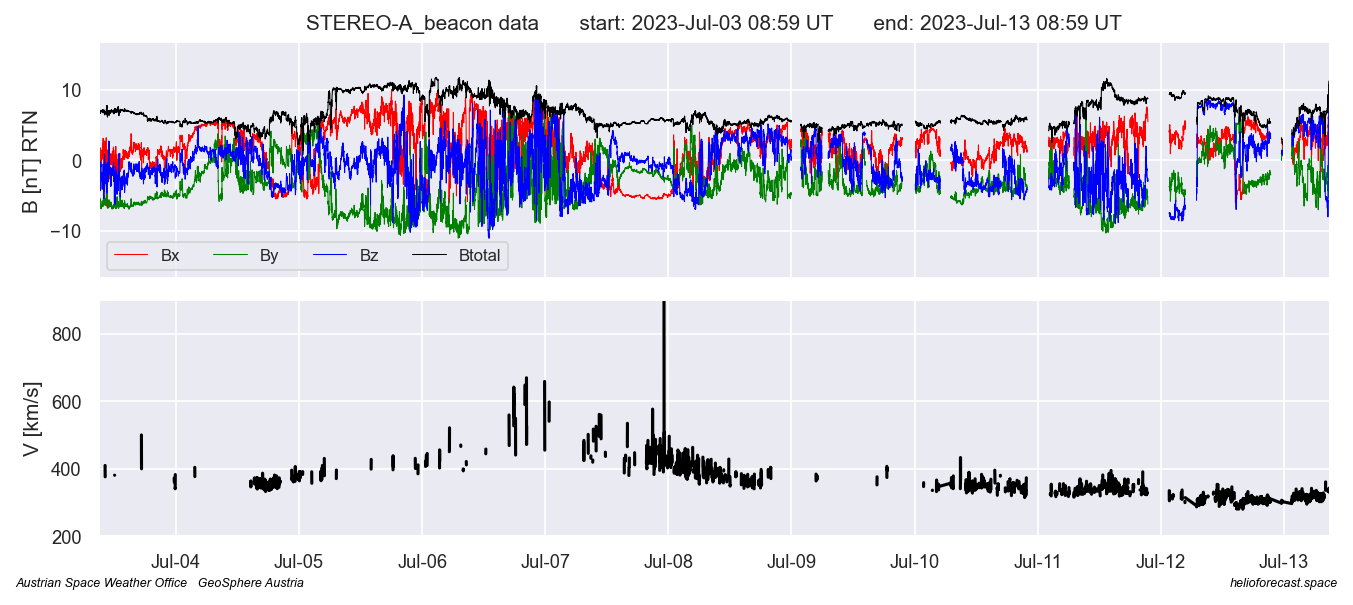

In [4]:
print(' ')
print('------ download STEREO-A beacon data ')
print(' ')


if get_stereoa > 0:
    hd.stereoa_download_beacon(start_year=datetime.datetime.utcnow().year,start_month=datetime.datetime.utcnow().month,start_day=datetime.datetime.utcnow().day-5,stereoa_path=stereoa_path)   

print('------ process STEREO-A beacon data to pickle') 
   
#define filename
file_sta_beacon='stereoa_beacon_last_10days_now.p'   

#save pickle file
hd.save_stereoa_beacon_data(stereoa_path,file_sta_beacon,datetime.datetime.utcnow()-datetime.timedelta(days=10),datetime.datetime.utcnow(),coord='RTN' )   
    
#load pickle    
[sta,hsta]=pickle.load(open(data_path+file_sta_beacon, "rb" ) )  

#plot
start=datetime.datetime.utcnow() - datetime.timedelta(days=10)
end=datetime.datetime.utcnow() 
hp.plot_insitu_update_stereoa_beacon(sta, start, end,'STEREO-A_beacon',plot_path+'stereoa/',now=True)
    

### positions and SDO plot

In [5]:

t0 = time.time()
print(' ')
print('------ POSITIONS ')

# spacecraft positions image
hp.plot_positions(datetime.datetime.utcnow(),position_path, 'HEEQ',now=True)

print(' ')
print('------ SDO realtime images ')


# get current SDO images 
hd.get_sdo_realtime_image(sun_path)



t1 = time.time()

print()
print('Positions and SDO images takes', np.round(t1-t0,2), 'seconds')




 
------ POSITIONS 
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_2023_Jul_13.png
saved as  /Users/chris/python/data/insitu_python/plots_positions/positions_now.png
 
------ SDO realtime images 
saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_0193.jpg
saved  /Users/chris/python/data/insitu_python/plots_sun/latest_1024_HMIB.jpg

Positions and SDO images takes 2.45 seconds


In [7]:

t1all = time.time()

print(' ')
print(' ')
print(' ')
print('------------------')
print('Runtime for full high frequency data update:', np.round((t1all-t0all),2), 'seconds')
print('--------------------------------------------------------------------------------------')



 
 
 
------------------
Runtime for full high frequency data update: 39.55 seconds
--------------------------------------------------------------------------------------
